# Adult Income Model Bias Analysis

## Import Dependencies

In [1]:
# !pip install researchpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from dataclasses import dataclass

In [5]:
%matplotlib inline

In [6]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [7]:
from sklearn.metrics import confusion_matrix

# Custom functions

#### Dataclass for confusion matrix results

In [8]:
@dataclass
class cmatrix:
    name: str
    TP: int
    FP: int
    TN: int
    FN: int    
    PPV: float
    TPR: float
    FDR: float
    FPR: float
    FOR: float
    FNR: float
    NPV: float
    TNR: float

#### Helper function to generate dataclass _cmatrix_

In [9]:
def gen_dataclass(actual, pred, name):
    [TN, FP, FN, TP] = confusion_matrix(actual, pred).ravel()
    

    PPV = TP / (TP + FP)  # positive predictive value
    FDR = FP / (TP + FP)  # false discovery rate
    
    TPR = TP / (TP + FN)  # true positive rate
    FNR = FN / (TP + FN)  # false negative rate
    
    TNR = TN / (TN + FP)  # true negative rate
    FPR = FP / (TN + FP)  # false positive rate

    FOR = FN / (TN + FN)  # false omission rate
    NPV = TN / (TN + FN)  # negative predictive value

    
    return cmatrix(name, TP, FP, TN, FN, PPV, TPR, FDR, FPR, FOR, FNR, NPV, TNR)

#### Extract bias metrics

In [10]:
def bias_metrics(df):
    '''
    - takes dataframe as input
    - returns dataclass whose components are statistical measures from a confusion matrix
    particular to relu, tanh, elu, and leaky relu dataframe series
    '''
    actual = df.target.values
    relu = df.pred_relu.values
    tanh = df.pred_tanh.values
    elu = df.pred_elu.values
    leaky = df.pred_leaky.values
    
    relu = gen_dataclass(actual, relu, "relu")
    tanh = gen_dataclass(actual, tanh, "tanh")
    elu = gen_dataclass(actual, elu, "elu")
    leaky = gen_dataclass(actual, leaky, "leaky")
    
    return relu, tanh, elu, leaky

# Import Data

In [11]:
data = pd.read_parquet("adult_results_mk4.parquet")

In [12]:
data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,gender,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target,pred_relu,pred_tanh,pred_elu,pred_leaky
0,22,171176,9,0,0,48,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,57,142714,10,0,0,38,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,34,228873,13,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,37,31670,9,0,0,60,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,61,115023,9,0,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [13]:
features = list(data.columns[-5:])
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

#### Inspect Data

**Note:** The following confusion matrix should return a list of four (4) numbers, with zero (0) false negatives and false positives. Example: array([100, 0, 0, 10])

In [14]:
confusion_matrix(data.target, data.target).ravel()

array([7417,    0,    0, 2352])

In [15]:
print("Name\t    Total   TP     FP   TN     FN")
for f in features:
    total = data[f].sum()
    try:
        [tn, fp, fn, tp] = confusion_matrix(data.target, data[f]).ravel()
    except Exception:
        pass
    print(f"{f:10s}: {total:5.0f}  {tp:5.0f} {fp:5.0f} {tn:6.0f} {fn:5.0f}")

Name	    Total   TP     FP   TN     FN
target    :  2352   2352     0   7417     0
pred_relu :  2116   1528   588   6829   824
pred_tanh :  2060   1484   576   6841   868
pred_elu  :  2006   1467   539   6878   885
pred_leaky:  2151   1535   616   6801   817


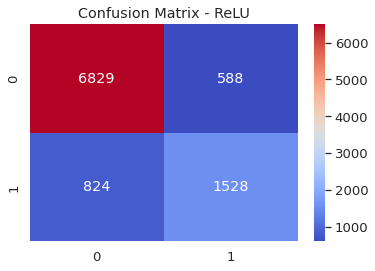

In [16]:
cm_relu = confusion_matrix(data.target, data.pred_relu)
sns.set(font_scale=1.2)
sns.heatmap(cm_relu, annot=True, cmap="coolwarm", robust=True, fmt='g')
plt.title("Confusion Matrix - ReLU")
plt.show()

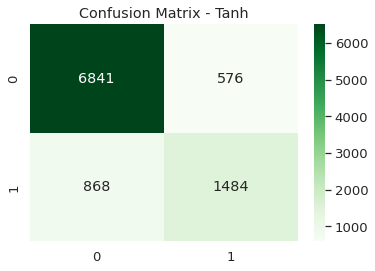

In [17]:
cm_tanh = confusion_matrix(data.target, data.pred_tanh)
sns.set(font_scale=1.2)
sns.heatmap(cm_tanh, annot=True, cmap="Greens", robust=True, fmt='g')
plt.title("Confusion Matrix - Tanh")
plt.show()

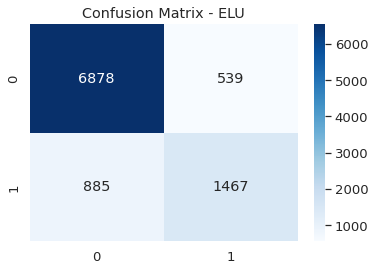

In [18]:
cm_elu = confusion_matrix(data.target, data.pred_elu)
sns.set(font_scale=1.2)
sns.heatmap(cm_elu, annot=True, cmap="Blues", robust=True, fmt='g')
plt.title("Confusion Matrix - ELU")
plt.show()

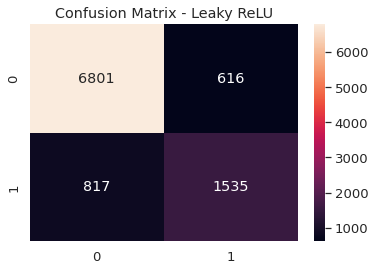

In [19]:
cm_leaky = confusion_matrix(data.target, data.pred_leaky)
sns.set(font_scale=1.2)
sns.heatmap(cm_leaky, annot=True, fmt='g')
plt.title("Confusion Matrix - Leaky ReLU")
plt.show()

## Separate by protected feature

In [20]:
# group A : protected attribute
# group B : other
GroupA = data[data["gender"] == 1]
GroupB = data[data["gender"] == 0]
attribute = ["female", "male"]

In [21]:
GroupA.shape

(3292, 112)

In [22]:
GroupB.shape

(6477, 112)

In [23]:
data.shape

(9769, 112)

##### Control stats, baseline

In [24]:
Cr, Ct, Ce, Cl = bias_metrics(data)

In [25]:
Ct.TPR

0.6309523809523809

##### Stats for Group A and Group B dataframes

In [26]:
Ar, At, Ae, Al = bias_metrics(GroupA)
Br, Bt, Be, Bl = bias_metrics(GroupB)

In [27]:
At.TPR

0.5317919075144508

# Bias Testing

#### Predictive parity

Compares precision (or positive predictive value, PPV) between group with protected attribute and without protected attribute. In this instance female group with male group

In [28]:
pp = [
    Ar.PPV == Br.PPV,
    At.PPV == Bt.PPV,
    Ae.PPV == Be.PPV,
    Al.PPV == Bl.PPV
]

In [29]:
pp_diff_r = 1 - (min(Ar.PPV,Br.PPV)/ max(Ar.PPV, Br.PPV))
pp_diff_t = 1 - (min(At.PPV, Bt.PPV)/ max(At.PPV, Bt.PPV))
pp_diff_e = 1 - (min(Ae.PPV, Be.PPV)/ max(Ae.PPV, Be.PPV))
pp_diff_l = 1 - (min(Al.PPV, Bl.PPV)/ max(Al.PPV, Bl.PPV))

In [30]:
print("Predictive parity -")
one = "PPV"
two = "FDR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}Difference")
print(f"{Ar.name}\t{pp[0]}\t{Ar.FDR == Br.FDR}\t{Ar.PPV:0.5f}\t{Br.PPV:10.5f}\t{pp_diff_r:0.5f}")
print(f"{At.name}\t{pp[1]}\t{At.FDR == Bt.FDR}\t{At.PPV:0.5f}\t{Bt.PPV:10.5f}\t{pp_diff_t:0.5f}")
print(f"{Ae.name}\t{pp[2]}\t{Ae.FDR == Be.FDR}\t{Ae.PPV:0.5f}\t{Be.PPV:10.5f}\t{pp_diff_e:0.5f}")
print(f"{Al.name}\t{pp[3]}\t{Al.FDR == Bl.FDR}\t{Al.PPV:0.5f}\t{Bl.PPV:10.5f}\t{pp_diff_l:0.5f}")

Predictive parity -
Name	PPV	FDR	PPV        FDR       Difference
relu	False	False	0.68092	   0.72903	0.06599
tanh	False	False	0.68148	   0.72626	0.06165
elu	False	False	0.69343	   0.73730	0.05950
leaky	False	False	0.68439	   0.71838	0.04732


In [31]:
Cr

cmatrix(name='relu', TP=1528, FP=588, TN=6829, FN=824, PPV=0.722117202268431, TPR=0.6496598639455783, FDR=0.277882797731569, FPR=0.07927733585007415, FOR=0.10767019469489089, FNR=0.35034013605442177, NPV=0.8923298053051091, TNR=0.9207226641499259)

#### Predictive Equality

Also called the False Positive Error Balance, this metric considers compares the false positive rates (FPR) between groups.

In [32]:
pe = [
    Ar.FPR == Br.FPR,
    At.FPR == Bt.FPR,
    Ae.FPR == Be.FPR,
    Al.FPR == Bl.FPR    
]

In [33]:
pe_diff_r = 1-(min(Ar.FPR, Br.FPR)/max(Ar.FPR, Br.FPR))
pe_diff_t = 1-(min(At.FPR, Bt.FPR)/max(At.FPR, Bt.FPR))
pe_diff_e = 1-(min(Ae.FPR, Be.FPR)/max(Ae.FPR, Be.FPR))
pe_diff_l = 1-(min(Al.FPR, Bl.FPR)/max(Al.FPR, Bl.FPR))

In [34]:
print("Predictive equality -")
one = "FPR"
two = "TNR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}\tDifference")
print(f"{Ar.name}\t{pe[0]}\t{Ar.TNR == Br.TNR}\t{Ar.FPR:0.5f}\t{Br.FPR:10.5f}\t{pe_diff_r:0.5f}")
print(f"{At.name}\t{pe[1]}\t{At.TNR == Bt.TNR}\t{At.FPR:0.5f}\t{Bt.FPR:10.5f}\t{pe_diff_t:0.5f}")
print(f"{Ae.name}\t{pe[2]}\t{Ae.TNR == Be.TNR}\t{Ae.FPR:0.5f}\t{Be.FPR:10.5f}\t{pe_diff_e:0.5f}")
print(f"{Al.name}\t{pe[3]}\t{Al.TNR == Bl.TNR}\t{Al.FPR:0.5f}\t{Bl.FPR:10.5f}\t{pe_diff_l:0.5f}")

Predictive equality -
Name	FPR	TNR	FPR        TNR       	Difference
relu	False	False	0.03293	   0.10982	0.70018
tanh	False	False	0.02919	   0.10960	0.73364
elu	False	False	0.02851	   0.10177	0.71982
leaky	False	False	0.03225	   0.11653	0.72327


#### Equal opportunity

Equal Opportunity entails equal false negative rates (FNR) between groups. Mathematically, true postive rates (TPR) should also be equal.

In [35]:
eo = [
    Ar.FNR == Br.FNR,
    At.FNR == Bt.FNR,
    Ae.FNR == Be.FNR,
    Al.FNR == Bl.FNR
]

In [36]:
eo_diff_r = 1 - (min(Ar.FNR, Br.FNR) / max(Ar.FNR, Br.FNR))
eo_diff_t = 1 - (min(At.FNR, Bt.FNR) / max(At.FNR, Bt.FNR))
eo_diff_e = 1 - (min(Ae.FNR, Be.FNR) / max(Ae.FNR, Be.FNR))
eo_diff_l = 1 - (min(Al.FNR, Bl.FNR) / max(Al.FNR, Bl.FNR))

In [37]:
print("Predictive parity -")
one = "FNR"
two = "TPR"
print(f"Name\t{one}\t{two}\t{one:11s}{two:10s}Difference")
print(f"{Ar.name}\t{eo[0]}\t{Ar.TPR == Br.TPR}\t{Ar.FNR:0.5f}\t{Br.FNR:10.5f}\t{eo_diff_r:0.5f}")
print(f"{At.name}\t{eo[1]}\t{At.TPR == Bt.TPR}\t{At.FNR:0.5f}\t{Bt.FNR:10.5f}\t{eo_diff_t:0.5f}")
print(f"{Ae.name}\t{eo[2]}\t{Ae.TPR == Be.TPR}\t{Ae.FNR:0.5f}\t{Be.FNR:10.5f}\t{eo_diff_e:0.5f}")
print(f"{Al.name}\t{eo[3]}\t{Al.TPR == Bl.TPR}\t{Al.FNR:0.5f}\t{Bl.FNR:10.5f}\t{eo_diff_l:0.5f}")

Predictive parity -
Name	FNR	TPR	FNR        TPR       Difference
relu	False	False	0.40173	   0.34148	0.15000
tanh	False	False	0.46821	   0.35194	0.24832
elu	False	False	0.45087	   0.36341	0.19398
leaky	False	False	0.40462	   0.33749	0.16592


#### Statistical Parity

Statistical Parity compares the accuracy of different groups.

In [38]:
Ar_acc = (Ar.TP + Ar.TN) / (Ar.TP + Ar.TN + Ar.FP + Ar.FN)
Br_acc = (Br.TP + Br.TN) / (Br.TP + Br.TN +Br.FP + Br.FN)
r_diff = 1 - (min(Ar_acc, Br_acc) / max(Ar_acc, Br_acc))

In [39]:
At_acc = (At.TP + At.TN) / (At.TP + At.TN + At.FP + At.FN)
Bt_acc = (Bt.TP + Bt.TN) / (Bt.TP + Bt.TN + Bt.FP + Bt.FN)
t_diff = 1 - (min(At_acc, Bt_acc) / max(At_acc, Bt_acc))

In [40]:
Ae_acc = (Ae.TP + Ae.TN) / (Ae.TP + Ae.TN + Ae.FP + Ae.FN)
Be_acc = (Be.TP + Be.TN) / (Be.TP + Be.TN + Be.FP + Be.FN)
e_diff = 1 - (min(Ae_acc, Be_acc) / max(Ae_acc, Be_acc))

In [41]:
Al_acc = (Al.TP + Al.TN) / (Al.TP + Al.TN + Al.FP + Al.FN)
Bl_acc = (Bl.TP + Bl.TN) / (Bl.TP + Bl.TN + Bl.FP + Bl.FN)
l_diff = 1 - (min(Al_acc, Bl_acc) / max(Al_acc, Bl_acc))

In [42]:
sp = [
    Ar_acc == Br_acc,
    At_acc == Bt_acc,
    Ae_acc == Be_acc,
    Al_acc == Bl_acc
]

In [43]:
print("Statistical Parity")
one = f"ACC-{attribute[0][0].capitalize()}"
two = f"ACC-{attribute[1][0].capitalize()}"
print(f"Name\tEqual\t{one:11s}{two}\tDifference")
print(f"{Ar.name}\t{sp[0]}\t{Ar_acc:0.5f}\t{Br_acc:10.5f}\t{r_diff:0.5f}")
print(f"{At.name}\t{sp[1]}\t{At_acc:0.5f}\t{Bt_acc:10.5f}\t{t_diff:0.5f}")
print(f"{Ae.name}\t{sp[2]}\t{Ae_acc:0.5f}\t{Be_acc:10.5f}\t{e_diff:0.5f}")
print(f"{Al.name}\t{sp[3]}\t{Al_acc:0.5f}\t{Bl_acc:10.5f}\t{l_diff:0.5f}")

Statistical Parity
Name	Equal	ACC-F      ACC-M	Difference
relu	False	0.92831	   0.81843	0.11836
tanh	False	0.92467	   0.81535	0.11823
elu	False	0.92710	   0.81720	0.11854
leaky	False	0.92861	   0.81504	0.12231


In [44]:
Aset = GroupA.iloc[:,-5:]
Bset = GroupB.iloc[:,-5:]
base = data.iloc[:,-5:]

#### Compare Variances

In [45]:
np.var(Aset)

target        0.094057
pred_relu     0.083817
pred_tanh     0.075290
pred_elu      0.076304
pred_leaky    0.083074
dtype: float64

In [46]:
np.var(Bset)

target        0.213790
pred_relu     0.201494
pred_tanh     0.199986
pred_elu      0.195901
pred_leaky    0.204044
dtype: float64

In [47]:
np.var(base)

target        0.182795
pred_relu     0.169686
pred_tanh     0.166404
pred_elu      0.163178
pred_leaky    0.171704
dtype: float64

In [48]:
np.var(base) == np.var(Aset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [49]:
np.var(base) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [50]:
np.var(Aset) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

# Hypothesis Testing

### Actual results

#### Control and Group A

In [51]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(base["target"], Aset["target"], equal_variances=False)[1][2:4]

Control and Female


,Welch's t-test,results
2,t =,19.7263
3,Two side test p value =,0.0000


#### Control and Group B

In [52]:
print(f"Baseline and {attribute[1].capitalize()}")
rp.ttest(base["target"], Bset["target"], equal_variances=False)[1][2:4]

Baseline and Male


,Welch's t-test,results
2,t =,-9.5869
3,Two side test p value =,0.0000


#### Group A and Group B

In [53]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["target"], Bset["target"], equal_variances=False)[1][2:4]

Female and Male


,Welch's t-test,results
2,t =,-26.071
3,Two side test p value =,0.000


### Tanh Results

#### Control and Group A

In [54]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(base["pred_tanh"], Aset["pred_tanh"], equal_variances=False)[1][2:4]

Control and Female


,Welch's t-test,results
2,t =,20.3957
3,Two side test p value =,0.0000


#### Control and Group B

In [55]:
print(f"Control and {attribute[1].capitalize()}")
rp.ttest(base["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4]

Control and Male


,Welch's t-test,results
2,t =,-9.4611
3,Two side test p value =,0.0000


#### Group A and Group B

In [56]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["pred_tanh"], Bset["pred_tanh"], equal_variances=False)[1][2:4]

Female and Male


,Welch's t-test,results
2,t =,-26.5063
3,Two side test p value =,0.0000


### ELU Results

#### Control and Group A

In [57]:
print(f"Control and {attribute[0].capitalize()}")
rp.ttest(Aset["pred_elu"], base["pred_elu"], equal_variances=False)[1][2:4]

Control and Female


,Welch's t-test,results
2,t =,-19.3338
3,Two side test p value =,0.0000


#### Control and Group B

In [58]:
print(f"Control and {attribute[1].capitalize()}")
rp.ttest(base["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4]

Control and Male


,Welch's t-test,results
2,t =,-9.0573
3,Two side test p value =,0.0000


#### Group A and Group B

In [59]:
print(f"{attribute[0].capitalize()} and {attribute[1].capitalize()}")
rp.ttest(Aset["pred_elu"], Bset["pred_elu"], equal_variances=False)[1][2:4]

Female and Male


,Welch's t-test,results
2,t =,-25.195
3,Two side test p value =,0.000


### Difference tests

**NOTE:** The variables of this test are dependent on the names of the particular dataset features.

In [60]:
rp.difference_test("target ~ C(gender)",
                   data=data,
                   equal_variances=False).conduct()

(       Name        N      Mean  Variance        SD        SE  95% Conf.  \
 0         0   9762.0  0.205491  0.163281   0.40408  0.004090   0.197474   
 1         1   9711.0  0.035630  0.034364  0.185375  0.001881   0.031942   
 2  combined  19473.0  0.120783    0.1062  0.325883  0.002335   0.116205   
 3      diff           0.169861                      0.004502   0.161037   
 
    Interval  
 0  0.213507  
 1  0.039317  
 2  0.125360  
 3  0.178685  ,
              Welch's t-test        Results
 0        Difference (0 - 1)   1.698610e-01
 1      Degrees of freedom =   1.371192e+04
 2                       t =   3.773308e+01
 3  Two sided test p-value =  1.572025e-296
 4  Difference < 0 p-value =   1.000000e+00
 5  Difference > 0 p-value =   0.000000e+00)

## Selection Rates and Impact

#### Baseline

In [61]:
col = "target"
sr_A = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_base = min(sr_A, sr_B) / max(sr_A, sr_B)

In [62]:
print("Selection Rate and Impact - control")
print(f"{attribute[0].capitalize()}:\t{sr_A:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B:0.5f}")
print(f"Impact:\t{impact_base:0.5f}")

Selection Rate and Impact - control
Female:	0.03542
Male:	0.20534
Impact:	0.17248


#### ReLU

In [63]:
col = "pred_relu"
sr_A_relu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_relu = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_relu = min(sr_A_relu, sr_B_relu) / max(sr_A_relu, sr_B_relu)

In [64]:
print("Selection Rate and Impact - ReLU")
print(f"{attribute[0].capitalize()}:\t{sr_A_relu:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_relu:0.5f}")
print(f"Impact:\t{impact_relu:0.5f}")

Selection Rate and Impact - ReLU
Female:	0.03112
Male:	0.18548
Impact:	0.16777


#### Tanh

In [65]:
col = "pred_tanh"
sr_A_tanh = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_tanh = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_tanh = min(sr_A_tanh, sr_B_tanh) / max(sr_A_tanh, sr_B_tanh)

In [66]:
print("Selection Rate and Impact - Tanh")
print(f"{attribute[0].capitalize()}:\t{sr_A_tanh:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_tanh:0.5f}")
print(f"Impact:\t{impact_tanh:0.5f}")

Selection Rate and Impact - Tanh
Female:	0.02764
Male:	0.18323
Impact:	0.15084


#### ELU

In [67]:
col = "pred_elu"
sr_A_elu = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_elu = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_elu = min(sr_A_elu, sr_B_elu) / max(sr_A_elu, sr_B_elu)

In [68]:
print("Selection Rate and Impact - elu")
print(f"{attribute[0].capitalize()}:\t{sr_A_elu:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_elu:0.5f}")
print(f"Impact:\t{impact_elu:0.5f}")

Selection Rate and Impact - elu
Female:	0.02805
Male:	0.17730
Impact:	0.15820


#### Leaky ReLU

In [69]:
col = "pred_leaky"
sr_A_leaky = Aset[Aset[col] == 1].shape[0] / data.shape[0]
sr_B_leaky = Bset[Bset[col] == 1].shape[0] / data.shape[0]
impact_leaky = min(sr_A_leaky, sr_B_leaky) / max(sr_A_leaky, sr_B_leaky)

In [70]:
print("Selection Rate and Impact - leaky")
print(f"{attribute[0].capitalize()}:\t{sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()}:\t{sr_B_leaky:0.5f}")
print(f"Impact:\t{impact_leaky:0.5f}")

Selection Rate and Impact - leaky
Female:	0.03081
Male:	0.18937
Impact:	0.16270


# Results

In [71]:
print(" "*12, "Selection Rate and Impact")
print("Group\tBase\t ReLU\t  Tanh\t   ELU\t    Leaky")
print(f"{attribute[0].capitalize()}: {sr_A:0.5f}  {sr_A_relu:0.5f}  {sr_A_tanh:0.5f}  {sr_A_elu:0.5f}  {sr_A_leaky:0.5f}")
print(f"{attribute[1].capitalize()}  : {sr_B:0.5f}  {sr_B_relu:0.5f}  {sr_B_tanh:0.5f}  {sr_B_elu:0.5f}  {sr_B_leaky:0.5f}")
print(f"Impact: {impact_base:0.5f}  {impact_relu:0.5f}  {impact_tanh:0.5f}  {impact_elu:0.5f}  {impact_leaky:0.5f}")

             Selection Rate and Impact
Group	Base	 ReLU	  Tanh	   ELU	    Leaky
Female: 0.03542  0.03112  0.02764  0.02805  0.03081
Male  : 0.20534  0.18548  0.18323  0.17730  0.18937
Impact: 0.17248  0.16777  0.15084  0.15820  0.16270


In [72]:
print(" "*12, "Bias Metrics")
print("*" * 37)
labels = ["Func.","PP","PE","EO","SP"]
fns = ["ReLU", "Tanh", "ELU", "Leaky"]
print(f"{labels[0]}\t{labels[1]}\t{labels[2]}\t{labels[3]}\t{labels[4]}")
for i in range(0,4):
    print(f"{fns[i]}\t{pp[i]}\t{pe[i]}\t{eo[i]}\t{sp[i]}")


print("\n\nLegend")
print(" - PP : predictive parity\n" +
      " - PE : predictive equality\n" +
      " - EO : equal opportunity\n" +
      " - SP : statistical parity")

             Bias Metrics
*************************************
Func.	PP	PE	EO	SP
ReLU	False	False	False	False
Tanh	False	False	False	False
ELU	False	False	False	False
Leaky	False	False	False	False


Legend
 - PP : predictive parity
 - PE : predictive equality
 - EO : equal opportunity
 - SP : statistical parity


In [73]:
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

# Similarity Metrics

#### Import Metrics Libraries

In [74]:
import Levenshtein as lev
from pyjarowinkler import distance as dist

#### Convert to string

In [75]:
Astr = [[""] * Aset.shape[0]] * Aset.shape[1]
Bstr = [[""] * Bset.shape[0]] * Bset.shape[1]

In [76]:
for f in range(len(features)):
    Astr[f] = ''.join(GroupA[features[f]].values.astype('int').astype('str'))
    Bstr[f] = ''.join(GroupB[features[f]].values.astype('int').astype('str'))

#### Test defaults
Levenshtein result should be 0

In [77]:
lev.distance(Astr[1], Astr[1])

0

Jaro similarity result should be 1.0

In [78]:
dist.get_jaro_distance(Astr[1], Astr[1])

1.0

In [79]:
for i, f in enumerate(features):
    print(f"{f:10s} : {i}")

target     : 0
pred_relu  : 1
pred_tanh  : 2
pred_elu   : 3
pred_leaky : 4


In [82]:
print("Similarity and Distance Metrics\n" \
      f"     Between {attribute[0].capitalize()} and {attribute[1].capitalize()}")
print("*" * 46)
print("Function\tLev.\tJaro\t  Jaro-Winkler")
for i, f in enumerate(features):
    print(f"{f:10s}:\t{lev.distance(Astr[i], Bstr[i])}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=False):7.5f}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=True):9.5f}")
    

Similarity and Distance Metrics
     Between Female and Male
**********************************************
Function	Lev.	Jaro	  Jaro-Winkler
target    :	3185	0.80460	  0.88000
pred_relu :	3185	0.80733	  0.88000
pred_tanh :	3185	0.81047	  0.89000
pred_elu  :	3185	0.80996	  0.89000
pred_leaky:	3185	0.80733	  0.88000


# Distribution Tests

Test results for shape of distribution

In [83]:
from scipy.stats import binom, chisquare, kstest

In [84]:
for f in features:
    test = data[f]

    x = test.values
    n = test.sum()
    p = n / test.shape[0]

    stat, pval = kstest(rvs=x, cdf=binom.cdf(x, n, p))
    print(f"Binom  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if stat > 0.5:
        print("  X")
    else:
        print()

    stat, pval = kstest(rvs=x, cdf='norm')
    print(f"Norm   - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")    
    if stat > 0.5:
        print("  X")
    else:
        print()
    
    freqB = data.target.sum()
    stat, pval = chisquare([n, freqB])
    print(f"Chi^2  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if pval > stat:
        print("  same as actual\n")
    else:
        print("\n")

Binom  - target    :       0.75924    0.00  X
Norm   - target    :       0.50000    0.00
Chi^2  - target    :       0.00000    1.00  same as actual

Binom  - pred_relu :       0.78340    0.00  X
Norm   - pred_relu :       0.50000    0.00
Chi^2  - pred_relu :      12.46553    0.00

Binom  - pred_tanh :       0.78913    0.00  X
Norm   - pred_tanh :       0.50000    0.00
Chi^2  - pred_tanh :      19.32548    0.00

Binom  - pred_elu  :       0.79466    0.00  X
Norm   - pred_elu  :       0.50000    0.00
Chi^2  - pred_elu  :      27.47040    0.00

Binom  - pred_leaky:       0.77981    0.00  X
Norm   - pred_leaky:       0.50000    0.00
Chi^2  - pred_leaky:       8.97202    0.00

